In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"allagowf","key":"ce7347df075d1f0ba95cf15af594575f"}'}

In [0]:
!mv kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 2.61G/2.62G [00:41<00:00, 68.0MB/s]
100% 2.62G/2.62G [00:41<00:00, 68.0MB/s]


In [0]:
!unzip skin-cancer-mnist-ham10000.zip

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: hmnist_28_28_RGB.csv    
  inflating: HAM10000_metadata.csv   
  inflating: HAM10000_images_part_1.zip  
  inflating: hmnist_28_28_L.csv      
  inflating: hmnist_8_8_L.csv        
  inflating: HAM10000_images_part_2.zip  
  inflating: hmnist_8_8_RGB.csv      


In [0]:
!unzip HAM10000_images_part_1.zip -d ham10000_images_part_1
!unzip HAM10000_images_part_2.zip -d ham10000_images_part_2

Archive:  HAM10000_images_part_1.zip
  inflating: ham10000_images_part_1/ISIC_0024306.jpg  
  inflating: ham10000_images_part_1/ISIC_0024307.jpg  
  inflating: ham10000_images_part_1/ISIC_0024308.jpg  
  inflating: ham10000_images_part_1/ISIC_0024309.jpg  
  inflating: ham10000_images_part_1/ISIC_0024310.jpg  
  inflating: ham10000_images_part_1/ISIC_0024311.jpg  
  inflating: ham10000_images_part_1/ISIC_0024312.jpg  
  inflating: ham10000_images_part_1/ISIC_0024313.jpg  
  inflating: ham10000_images_part_1/ISIC_0024314.jpg  
  inflating: ham10000_images_part_1/ISIC_0024315.jpg  
  inflating: ham10000_images_part_1/ISIC_0024316.jpg  
  inflating: ham10000_images_part_1/ISIC_0024317.jpg  
  inflating: ham10000_images_part_1/ISIC_0024318.jpg  
  inflating: ham10000_images_part_1/ISIC_0024319.jpg  
  inflating: ham10000_images_part_1/ISIC_0024320.jpg  
  inflating: ham10000_images_part_1/ISIC_0024321.jpg  
  inflating: ham10000_images_part_1/ISIC_0024322.jpg  
  inflating: ham10000_images

In [0]:
# Skin Cancer Dataset Preprocessing


In [0]:
# Import the libraries
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
import shutil

Using TensorFlow backend.


In [0]:
# Create a new directory for the images
base_dir = 'base_dir'
os.mkdir(base_dir)


In [0]:
# Training file directory
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)



In [0]:
# Validation file directory
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


In [0]:
# Create new folders in the training directory for each of the classes
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# Create new folders in the validation directory for each of the classes
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



##Create Train and Val

In [0]:
# Read the metadata
df_data = pd.read_csv('HAM10000_metadata.csv')

# Display some information in the dataset
df_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [0]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [0]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [0]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [0]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [0]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [0]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [0]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [0]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [0]:
df_val['dx'].value_counts()


nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [0]:
# Print the shape of the training and validation split
print(df_train.shape)
print(df_val.shape)


(9077, 9)
(938, 8)


In [0]:
# Find the number of values in the training and validation set
df_train['dx'].value_counts()



nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [0]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

##Transfer the images into folders

In [0]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [0]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('ham10000_images_part_1')
folder_2 = os.listdir('ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [0]:
# Check how many training images are in each folder
nv = len(os.listdir('base_dir/train_dir/nv'))
mel = len(os.listdir('base_dir/train_dir/mel'))
bkl = len(os.listdir('base_dir/train_dir/bkl'))
bcc = len(os.listdir('base_dir/train_dir/bcc'))
akiec = len(os.listdir('base_dir/train_dir/akiec'))
vasc = len(os.listdir('base_dir/train_dir/vasc'))
df = len(os.listdir('base_dir/train_dir/df'))

print(nv)
print(mel)
print(bkl)
print(bcc)
print(akiec)
print(vasc)
print(df)

5954
1074
1024
484
301
131
109


In [0]:
# Check how many validation images are in each folder
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))


751
39
75
30
26
11
6


In [0]:
# Augment the data
# Class 'nv' is not going to be augmented
class_list = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

for item in class_list:

    # Create a temporary directory for the augmented images
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    # Create a directory within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # List all the images in the directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for fname in img_list:
        # source path to image
        src = os.path.join('base_dir/train_dir/' + img_class, fname)
        # destination path to image
        dst = os.path.join(img_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator to augment the images in real time
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        # brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    num_aug_images_wanted = 6000  # total number of images we want to have in each class
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')


Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [0]:
# Check how many train images are each folder (original + augmented)
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))


5954
5920
5920
5858
5217
5290
4410


In [0]:
# Check how many validation images are in each folder
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [0]:
# The model for the skin cancer classifier


In [0]:

# Import the libraries
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Activation, Dense


from keras.metrics import categorical_crossentropy

from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *


%matplotlib inline


In [0]:
# Check if GPU is available
 K.tensorflow_backend._get_available_gpus()


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
# The paths for the training and validation images
train_path = 'base_dir/train_dir'
val_path = 'base_dir/val_dir'



In [0]:

mobile_model = keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 1s 0us/step


In [0]:

mobile_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:

type(mobile_model)

keras.engine.training.Model

In [0]:
len(mobile_model.layers)

93

In [0]:
print(len(df_train))
print(len(df_val))

9077
938


In [0]:
# Declare a few useful values
num_train_samples = 38569 # len(df_train)
num_val_samples = len(df_val)
train_batch_size = 60
val_batch_size = 60
image_size = 224

In [0]:
# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_val_samples / val_batch_size)


In [0]:
# Set up generators
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=train_batch_size)

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False)


Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [0]:
for layer in mobile_model.layers:
    layer.trainable = True

In [0]:
# Modify the model
# Exclude the last 5 layers of the model
x = mobile_model.layers[-6].output
# Add a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# Create a new model with the new outputs
model = Model(inputs=mobile_model.input, outputs=predictions)



In [0]:
for layer in model.layers:
    layer.trainable = True
    

In [0]:
len(model.layers)

90

In [0]:
# See a summary of the new layers in the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
from keras.metrics import categorical_accuracy
from functools import partial


In [0]:
from keras.utils import np_utils
from itertools import product


In [0]:
w_array = np.ones((7,7))
w_array[4, 5] = 1.2
#w_array[5, 4] = 1.2
#w_array[5, 1] = 1.2
w_array[1, 5] = 1.2

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask
  
w_array = np.ones((7,7))
w_array[4, 5] = 1.2
#w_array[5, 4] = 1.2
#w_array[5, 1] = 1.2
w_array[1, 5] = 1.2
ncce = partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

In [0]:


INTERESTING_CLASS_ID = 4  # Choose the class of interest

def mel_sensitivity(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


In [0]:
INTERESTING_CLASS_ID = 4  # Choose the class of interest

def mel_specificity(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_true, INTERESTING_CLASS_ID), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

In [0]:
# Compile the model
model.compile(Adam(lr=0.001), loss = ncce, metrics=[categorical_accuracy,mel_sensitivity])


In [0]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [0]:
# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 1.0 / akiec ,  # akiec
    1: 1.0 / bcc * 5 ,  # bcc
    2: 1.0 / bkl ,  # bkl
    3: 1.0 / df ,  # df
    4: 1.0 / mel * 100,  # mel
    5: 1.0 / nv ,  # nv
    6: 1.0 / vasc ,  # vasc
}


In [0]:
print(class_weights)

{0: 0.0033222591362126247, 1: 0.010330578512396695, 2: 0.0009765625, 3: 0.009174311926605505, 4: 0.0931098696461825, 5: 0.00016795431642593214, 6: 0.007633587786259542}


In [0]:
# Declare the filepath for the saved model
filepath = "model.h5"

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_mel_sensitivity', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_mel_sensitivity', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              #class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=30,
                              verbose=1,
                              callbacks=callbacks_list)



Instructions for updating:
Use tf.cast instead.
Epoch 1/30
643/643 [==============================] - 423s 658ms/step - loss: 6.8132 - categorical_accuracy: 0.5832 - mel_sensitivity: 0.5200 - val_loss: 7.5212 - val_categorical_accuracy: 0.5341 - val_mel_sensitivity: 0.0884

Epoch 00001: val_mel_sensitivity improved from -inf to 0.08836, saving model to model.h5
Epoch 2/30
643/643 [==============================] - 410s 638ms/step - loss: 6.0593 - categorical_accuracy: 0.6286 - mel_sensitivity: 0.5516 - val_loss: 2.5717 - val_categorical_accuracy: 0.8454 - val_mel_sensitivity: 0.3847

Epoch 00002: val_mel_sensitivity improved from 0.08836 to 0.38474, saving model to model.h5
Epoch 3/30
643/643 [==============================] - 410s 638ms/step - loss: 5.7626 - categorical_accuracy: 0.6468 - mel_sensitivity: 0.5521 - val_loss: 6.0931 - val_categorical_accuracy: 0.6247 - val_mel_sensitivity: 0.3603

Epoch 00003: val_mel_sensitivity did not improve from 0.38474
Epoch 4/30
643/643 [========

In [0]:
#
#
#
#

In [0]:
from keras.models import load_model
model = load_model('model.h5', custom_objects={'mel_sensitivity': mel_sensitivity , 'w_categorical_crossentropy':ncce})


In [0]:
# Evaluate the model
# Evaluation of the last epoch
val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)



In [0]:
# Evaluation of the best epoch
model.load_weights('model.h5')

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)



In [0]:
# Create a confusion matrix of the test images
test_labels = test_batches.classes


In [0]:
# Make predictions
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)




16/16 [==============================] - 12s 749ms/step


Confusion matrix, without normalization
[[  0   0   0   0   0  26   0]
 [  0   0   1   0   0  29   0]
 [  0   0   2   0   0  73   0]
 [  0   0   0   0   0   6   0]
 [  0   0   0   0   1  38   0]
 [ 21  33  67   3  32 584  11]
 [  0   0   0   0   0  11   0]]


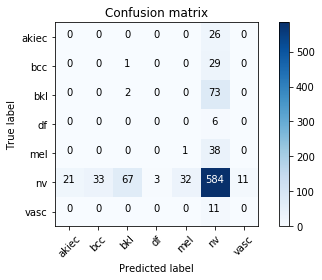

In [0]:
# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)

In [0]:

# Make predictions
predictions = model.predict_generator(test_batches, steps=test_steps, verbose=1)


# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

16/16 [==============================] - 11s 669ms/step


In [0]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        26
         bcc       0.00      0.00      0.00        30
         bkl       0.00      0.00      0.00        75
          df       0.00      0.00      0.00         6
         mel       0.00      0.00      0.00        39
          nv       0.76      0.78      0.77       751
        vasc       0.00      0.00      0.00        11

   micro avg       0.62      0.62      0.62       938
   macro avg       0.11      0.11      0.11       938
weighted avg       0.61      0.62      0.62       938



dict_keys(['val_loss', 'val_categorical_accuracy', 'val_mel_sensitivity', 'loss', 'categorical_accuracy', 'mel_sensitivity', 'lr'])


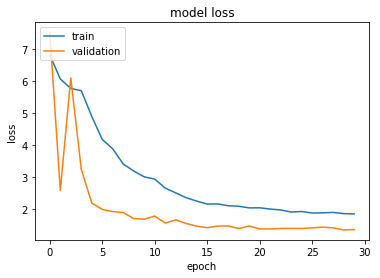

In [0]:
print(history.history.keys())


# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
modelname = 'modelmobile.h5'
modelweight = 'modelmobile_weight.h5'

!cp 'model.h5' -d modelname

In [0]:
from keras.preprocessing import image
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# 2. Save Keras Model or weights on google drive




# create on Colab directory
model.save(modelname)    
model_file = drive.CreateFile({'title' : modelname})
model_file.SetContentFile(modelname)
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})


In [0]:
model.save_weights(modelweight)
weights_file = drive.CreateFile({'title' : modelweight})
weights_file.SetContentFile(modelweight)
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

In [0]:
#file_id = '1gl4BWZ-AIi96drLlyiO5bKLpqueCHUMK' # URL id. 
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile(modelname)

In [0]:
#!unzip base_dir.zip

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp mobilenet_test_custom_loss_metrics.ipynb -d drive/My\ Drive/mobile_last_tests/mobilenet_test_custom_loss_metrics.ipynb